In [200]:
from copy import deepcopy
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [201]:
# Define the Lorenz '63 system of differential equations

# constants
sigma=10.
beta=8./3.
rho=28.

# derivative functions
def dxdt(x, y, z, t):
    return sigma * (y - x)

def dydt(x, y, z, t):
    return x * (rho - z) - y

def dzdt(x, y, z, t):
    return x * y - beta * z

lorenz_derivs = [dxdt, dydt, dzdt]

In [202]:
# Define the Runge-Kutta order 4 solver

def rk4(state, derivs, t, dt):
    x = list(state)

    args = x + [t]
    k1 = [ dt * f(*args) for f in derivs ]

    args = [ r+0.5*kr for r,kr in zip(x + [t], k1 + [dt]) ]
    k2 = [ dt * f(*args) for f in derivs ]

    args = [ r+0.5*kr for r,kr in zip(x + [t], k2 + [dt]) ]
    k3 = [ dt * f(*args) for f in derivs ]

    args = [ r+kr for r,kr in zip(x + [t], k3 + [dt]) ]
    k4 = [ dt * f(*args) for f in derivs ]

    return np.array( [r+(k1r+2*k2r+2*k3r+k4r)/6 for r,k1r,k2r,k3r,k4r in zip(x,k1,k2,k3,k4)] )

In [203]:
# Given a state (x, y, z) and a time step size dt, predict the next state of the system

def lorenz_step(state, dt):
    return rk4(state, lorenz_derivs, 0, dt)

In [204]:
def simulate_lorenz(state, t0, tFinal, dt, ):
    x0, y0, z0 = state
    steps = int(np.floor((tFinal-t0) / dt))

    t = steps * [0.0]
    x = steps * [0.0]
    y = steps * [0.0]
    z = steps * [0.0]

    x[0],y[0],z[0],t[0] = x0, y0, z0, t0  #Initial system state

    for i in range(1, steps):
        x[i],y[i],z[i] = lorenz_step( (x[i-1],y[i-1],z[i-1]) , dt)

    return x, y, z, t

In [205]:
x0, y0, z0, t0, tFinal, dt = 1., 1., 1., 0., 40., 0.01

x, y, z, t = simulate_lorenz( (x0, y0, z0) , t0, tFinal, dt)

/home/jacekline/installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  
/home/jacekline/installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


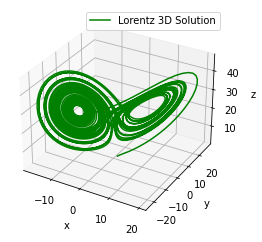

In [206]:
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.plot(x,y,z,'r',label='Lorentz 3D Solution', color = 'green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

In [207]:
# Helper functions for EnsembleKalmanFilter class

def pretty_str(label, arr):
    """
    Generates a pretty printed NumPy array with an assignment. Optionally
    transposes column vectors so they are drawn on one line.
    Examples
    --------
    >>> pprint('cov', np.array([[4., .1], [.1, 5]]))
    cov = [[4.  0.1]
           [0.1 5. ]]
    >>> print(pretty_str('x', np.array([[1], [2], [3]])))
    x = [[1 2 3]].T
    """

    def is_col(a):
        """ return true if a is a column vector"""
        try:
            return a.shape[0] > 1 and a.shape[1] == 1
        except (AttributeError, IndexError):
            return False

    if label is None:
        label = ''

    if label:
        label += ' = '

    if is_col(arr):
        return label + str(arr.T).replace('\n', '') + '.T'

    rows = str(arr).split('\n')
    if not rows:
        return ''

    s = label + rows[0]
    pad = ' ' * len(label)
    for line in rows[1:]:
        s = s + '\n' + pad + line

    return s

def outer_product_sum(A, B):
    """
    Computes the sum of the outer products of the rows in A and B.
    Parameters
    ----------
    A : np.array, shape (M, N)
        rows of N-vectors to have the outer product summed
    B : np.array, shape (M, N)
        rows of N-vectors to have the outer product summed
        If it is `None`, it is set to A.
    """
    if B is None:
            B = A

    outer = np.einsum('ij,ik->ijk', A, B)
    return np.sum(outer, axis=0)

In [208]:
class EnsembleKalmanFilter(object):
    """
    This implements the ensemble Kalman filter (EnKF).
    Parameters
    ----------
    x : np.array(dim_x)
        state mean
    P : np.array((dim_x, dim_x))
        covariance of the state
    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
    dt : float
        time step in seconds
    N : int
        number of sigma points (ensembles). Must be greater than 1.
    K : np.array
        Kalman gain
    hx : function hx(x)
        Measurement function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.
    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x.
    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate
    P : numpy.array(dim_x, dim_x)
        State covariance matrix
    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.
    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.
    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate. Read Only.
    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix. Read Only.
    z : numpy.array
        Last measurement used in update(). Read only.
    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix
    Q : numpy.array(dim_x, dim_x)
        Process noise matrix
    fx : callable (x, dt)
        State transition function
    hx : callable (x)
        Measurement function. Convert state `x` into a measurement
    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step. Read only.
    inv : function, default numpy.linalg.inv
        If you prefer another inverse function, such as the Moore-Penrose
        pseudo inverse, set it to that instead: kf.inv = np.linalg.pinv
    Examples
    --------
    .. code-block:: Python
        def hx(x):
           return np.array([x[0]])
        F = np.array([[1., 1.],
                      [0., 1.]])
        def fx(x, dt):
            return np.dot(F, x)
        x = np.array([0., 1.])
        P = np.eye(2) * 100.
        dt = 0.1
        f = EnsembleKalmanFilter(x=x, P=P, dim_z=1, dt=dt,
                                 N=8, hx=hx, fx=fx)
        std_noise = 3.
        f.R *= std_noise**2
        f.Q = Q_discrete_white_noise(2, dt, .01)
        while True:
            z = read_sensor()
            f.predict()
            f.update(np.asarray([z]))

    Reference: https://github.com/rlabbe/filterpy/blob/master/filterpy/kalman/ensemble_kalman_filter.py
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None] * self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty
        self.step = 0

        self.initialize(x, P)
        self.Q = np.eye(dim_x)       # process uncertainty
        self.R = np.eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for
        # state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)

    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__
        Parameters
        ----------
        x : np.array(dim_z)
            state mean
        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def time(self): # returns the current "time" of the system
        return self.step * self.dt

    def update(self, z, R=None): # Peforms data assimilation on a measurement and predicts next step
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.
        Parameters
        ----------
        z : np.array
            measurement for this update.
        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise self.R will be used.
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = np.eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = np.zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = (outer_product_sum(sigmas_h - z_mean) / (N-1)) + R
        P_xz = outer_product_sum(
            self.sigmas - self.x, sigmas_h - z_mean) / (N - 1)

        self.S = P_zz
        self.SI = self.inv(self.S)
        self.K = np.dot(P_xz, self.SI)

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += np.dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - np.dot(np.dot(self.K, self.S), self.K.T)

        # # predict next postition using ideal model from last ideal position
        # # tracks where the state would be if we did not use data assimilation

        # self.x_ideal = self.fx(self.x, self.dt)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

        self.step += 1

        return self.x

    def predict(self): # Predicts next step without an observation given
        """ Predict next position. """

        N = self.N

        # # predict next postition using ideal model from last ideal position
        # # tracks where the state would be if we did not use data assimilation

        # self.x_ideal = self.fx(self.x, self.dt)

        # predict next postition using EnKF from last EnKF 
        
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        self.x = np.mean(self.sigmas, axis=0)
        self.P = outer_product_sum(self.sigmas - self.x, self.sigmas - self.x) / (N - 1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

        self.step += 1

        return self.x

    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx),
            pretty_str('step', self.step)
            ])

In [209]:
def hx(x):
    return x

# x = np.array([1.0, 1.0, 1.0])
x = np.array([-8.606328530000000754e+00,-8.858544694714117540e+00,-9.115303102308624617e+00])
P = np.eye(3)
dt = 0.01

enkf = EnsembleKalmanFilter(x=x, P=P, dim_z=3, dt=dt, N=10, hx=hx, fx=lorenz_step)
enkf

EnsembleKalmanFilter object
dim_x = 3
dim_z = 3
dt = 0.01
x = [-8.60632853 -8.85854469 -9.1153031 ]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [-8.60632853 -8.85854469 -9.1153031 ]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
R = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
K = [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
S = [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
sigmas = [[ -7.45252962  -7.94298596  -9.87779028]
          [ -8.44267057  -8.96021919  -9.77188909]
          [ -8.57048521  -9.34657396 -10.15185377]
          [ -9.41048341  -8.63991952  -8.62115986]
          [ -6.59946954  -8.83546605  -9.79388752]
          [ -8.71366521  -8.77926482  -9.05564486]
          [ -7.50420096 -10.51985328  -8.80449732]
          [-10.3469065   -9.88413991  -8.81164699]
          [ -8.54267497  -9.26837297  -9.26381652]
          [ -9.68913123  -8.17809464  -7.24483614]]
hx = <function hx at 0x7f812a

In [210]:
multivariate_normal(enkf._mean, enkf.Q, enkf.N)

array([[ 1.9165255 ,  0.24400611,  0.12666483],
       [-0.35880937, -0.41217367, -0.2241149 ],
       [ 1.49833145,  0.10720729,  0.93964958],
       [ 0.34933078,  1.49985985, -0.11490983],
       [ 1.06922915, -0.32591967, -0.66285949],
       [-1.43510645,  0.72025464,  0.04400257],
       [ 0.79984995, -0.60897137,  1.92657135],
       [-0.76304509, -1.50312994,  0.10470462],
       [ 1.71154648, -0.54724629,  0.69502847],
       [ 0.04553592,  0.52544835,  0.22131105]])

In [211]:
for i in range(0,20):
    enkf.predict()

In [212]:
multivariate_normal(enkf._mean, enkf.Q, enkf.N)

array([[ 1.32180864,  1.00633148, -0.39663685],
       [-1.27275253,  0.086829  ,  0.5429293 ],
       [ 1.10048844, -0.3401289 , -0.24977089],
       [ 0.49046468, -1.38454286, -0.10657758],
       [ 2.80225144, -0.57074984,  2.00332055],
       [ 0.32810665,  1.07168888, -1.17700483],
       [-0.65379431,  0.16079143, -0.51035378],
       [-1.82224934,  0.12366372,  1.12440773],
       [-1.16205137,  0.37287212,  0.39969435],
       [-0.56927047, -1.2440303 , -0.18612858]])

In [217]:
multivariate_normal(np.zeros(3), enkf.Q)

array([-1.88451354, -1.3499842 ,  2.01834904])

In [ ]:
# generate random simulation of Lorenz '63 system using 